In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from utilities import *

from matplotlib import pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set(style="ticks", palette="deep")
cols = sns.color_palette()
# plt.style.use('v_arial')

Master folder with Stytra example data:

In [4]:
sample_data_path = Path("J:\_Shared\stytra\manuscript\datasets")

# Load all experiments:

In [14]:
master_path = Path(sample_data_path / "replication_portugues2011")
paths = list(master_path.glob('*f*'))
exps = [Experiment(path) for path in paths]

In [15]:
def get_exp_stats(exp):
    tail_log_df = exp.behavior_log.set_index("t")  # DataFrame with the tail trace
    stim_log_df = exp.stimulus_param_log.set_index("t")
    
    tail_dt = np.diff(tail_log_df.index).mean()  # time step size in tail trace df
    
    # Recalculate vigor from tail trace:
    vigor = tail_log_df["tail_sum"].rolling(int(0.05/tail_dt), center=True).std().as_matrix()
    
    # extract bouts
    bouts_idxs, _ = extract_segments_above_thresh(vigor, 0.6, min_duration=int(0.1/tail_dt), 
                                             pad_before=5, pad_after=5, skip_nan=True)
    # Calculate bouts start and end times:
    bout_starts = np.array([tail_log_df["tail_sum"].index[b[0]] for b in bouts_idxs])
    bout_ends = np.array([tail_log_df["tail_sum"].index[b[1]] for b in bouts_idxs])

    
    # Exclude trailing trial of gain 1:
    trial_s = stim_log_df.index[np.ediff1d(stim_log_df["closed loop 1D_gain"], to_begin=0) > 0][1:]
    trial_e = stim_log_df.index[np.ediff1d(stim_log_df["closed loop 1D_gain"], to_begin=0) < 0][1:]
    trial_g = stim_log_df["closed loop 1D_gain"][np.ediff1d(stim_log_df["closed loop 1D_gain"], to_begin=0) > 0].as_matrix()[1:]                    
    trial_df = pd.DataFrame(dict(start=trial_s, end=trial_e, gain=trial_g, inter_bout_t=np.nan, 
                                 trial_idx = [i for i in range(6) for _ in range(18)],
                                 bout_n=np.nan, bout_duration=np.nan, first_bout_latency=np.nan), 
                            index=np.arange(len(trial_s)))
    for i in range(len(trial_df)):
        bout_idxs = np.argwhere((bout_starts > trial_df.loc[i, "start"]) 
                                & (bout_ends < trial_df.loc[i, "end"]))[:,0]
        if len(bout_idxs) > 0:
            trial_df.loc[i, "bout_n"] = len(bout_idxs)
            trial_df.loc[i, "first_bout_latency"] = bout_starts[bout_idxs[0]] - trial_df.loc[i, "start"]
            trial_df.loc[i, "bout_duration"] = (bout_ends[bout_idxs] - bout_starts[bout_idxs]).mean()

            if len(bout_idxs) > 3:
                trial_df.loc[i, "inter_bout_t"] = (bout_starts[bout_idxs[1:]] - bout_ends[bout_idxs[:-1]]).mean()
                
    return trial_df
                
def cum_stat(stat_list, key):
    stat = np.array([np.nanmean(stat[key].as_matrix().reshape(6, 18), 0) for stat in stat_list]).T
    stat = stat/np.nanmean(stat[:3,:], 0)
    return stat

In [16]:
trial_stats = [get_exp_stats(exp) for exp in exps]

# Make figure

In [17]:
def back_color():
    plt.axvspan(-0.5, 2.5, color=(0.9,)*3)
    plt.axvspan(8.5, 11.5, color=(0.9,)*3)
    plt.axvspan(5.5, 8.5, color=(0.7,)*3)
    plt.axvspan(11.5, 14.5, color=(0.7,)*3)

<IPython.core.display.Javascript object>


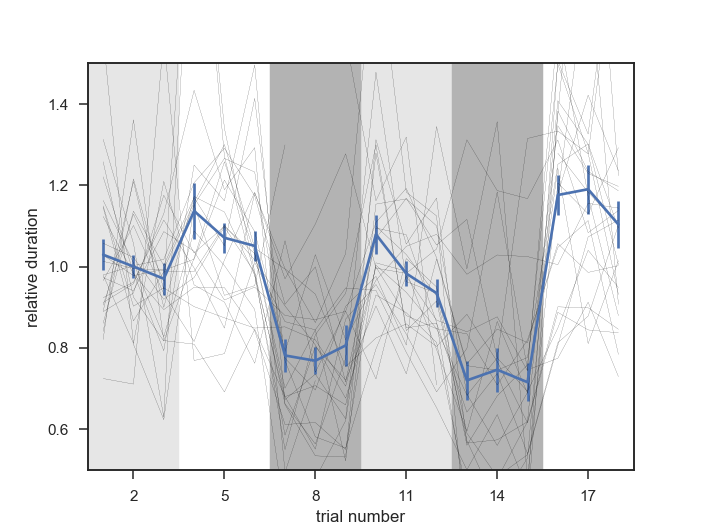

C:\Users\lpetrucco\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


In [18]:
final_fig = plt.figure()
k = 'inter_bout_t'
stat = cum_stat(trial_stats, k)
plt.errorbar(np.arange(stat.shape[0]), np.nanmean(stat, 1), np.nanstd(stat, 1)/np.sqrt(stat.shape[1]-1))
plt.plot(stat, linewidth = 0.1, c='k')
back_color()
plt.ylim(0.5,1.5)
plt.xlim((-0.5, 17.5))
plt.xticks(np.arange(1, 17, 3), np.arange(2, 18, 3))
plt.ylabel('relative duration')
plt.xlabel('trial number')

In [98]:
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['svg.fonttype'] = 'none'
final_fig.savefig("interbouts.svg", format="svg")